In [ ]:
"""
3/15/2021

Increase features:
    - YOLO detected eyes,nose,ears
    - num of facial features detected, position, width, height, avg width, avg height
    
Proper train test split:
    - use only unseen frames for testing
    - Random forest still performs the best (69%)

Examined selected best frame and false positives


"""

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white")

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score, log_loss

## Load data and create df
* .csv files already include both blurriness and face info (with more details)
* larger dataset(1832 rows)

In [2]:
bad = pd.read_csv('./OpenCV_blur/TEST_face_features_bad_bare.csv')
good = pd.read_csv('./OpenCV_blur/TEST_face_features_good_bare.csv')

In [3]:
len(bad),len(good)

(808, 1024)

In [4]:
test = pd.concat([bad,good],axis=0).reset_index(drop=True)
# test

In [5]:
import ast
# Convert to actual list and count number of eyes/ears/nose detected
test['eyes'] = test['eyes'].apply(lambda x: ast.literal_eval(x))
test['num_eye'] = test['eyes'].apply(lambda x: len(x))
test['ears'] = test['ears'].apply(lambda x: ast.literal_eval(x))
test['num_ear'] = test['ears'].apply(lambda x: len(x))
test['nose'] = test['nose'].apply(lambda x: ast.literal_eval(x))
test['num_nose'] = test['nose'].apply(lambda x: len(x))

In [6]:
test['eye_x1'] = test['eyes'].apply(lambda x: x[0][0] if (len(x)>0) else 0)
test['eye_y1'] = test['eyes'].apply(lambda x: x[0][1] if (len(x)>0) else 0)
test['eye_w1'] = test['eyes'].apply(lambda x: x[0][2] if (len(x)>0) else 0)
test['eye_x2'] = test['eyes'].apply(lambda x: x[1][0] if (len(x)>1) else 0)
test['eye_y2'] = test['eyes'].apply(lambda x: x[1][1] if (len(x)>1) else 0)
test['eye_w2'] = test['eyes'].apply(lambda x: x[1][2] if (len(x)>1) else 0)
test['eye_w'] = test['eyes'].apply(lambda x: sum([x[i][2] for i in range(len(x))])/len(x) if len(x)!=0 else 0)

test['eye_h1'] = test['eyes'].apply(lambda x: x[0][3] if (len(x)>0) else 0)
test['eye_h2'] = test['eyes'].apply(lambda x: x[1][3] if (len(x)>1) else 0)
test['eye_h'] = test['eyes'].apply(lambda x: sum([x[i][3] for i in range(len(x))])/len(x) if len(x)!=0 else 0)

test['eye_size'] = test['eye_w']*test['eye_h']
test['eye_ratio'] = test['eye_size'] / test['face_size']

In [7]:
test['ear_w1'] = test['ears'].apply(lambda x: x[0][2] if (len(x)>0) else 0)
test['ear_w2'] = test['ears'].apply(lambda x: x[1][2] if (len(x)>1) else 0)
test['ear_w'] = test['ears'].apply(lambda x: sum([x[i][2] for i in range(len(x))])/len(x) if len(x)!=0 else 0)

test['ear_h1'] = test['ears'].apply(lambda x: x[0][3] if (len(x)>0) else 0)
test['ear_h2'] = test['ears'].apply(lambda x: x[1][3] if (len(x)>1) else 0)
test['ear_h'] = test['ears'].apply(lambda x: sum([x[i][3] for i in range(len(x))])/len(x) if len(x)!=0 else 0)

In [8]:
test['nose_x'] = test['nose'].apply(lambda x: x[0][0] if (len(x)>0) else 0)
test['nose_y'] = test['nose'].apply(lambda x: x[0][1] if (len(x)>0) else 0)

In [9]:
# Add 'label' as the last column
label_list = ['bad']*bad.shape[0] + ['good']*good.shape[0]
test['label'] = label_list
test.iloc[:,:]

filename     lp_cat  \
0                                   IMG_0185.MOV_12.jpg   5.052993   
1                                  IMG_0185.MOV_156.jpg  12.748102   
2                                  IMG_0185.MOV_162.jpg  34.031338   
3                                  IMG_0185.MOV_168.jpg  35.830179   
4                                  IMG_0185.MOV_174.jpg  33.939300   
...                                                 ...        ...   
1827  joined_video_54ba02eb70fc40e4a4d6dd164fd11e70....  21.401767   
1828  joined_video_54ba02eb70fc40e4a4d6dd164fd11e70....  20.284242   
1829  joined_video_54ba02eb70fc40e4a4d6dd164fd11e70....  21.238435   
1830  joined_video_54ba02eb70fc40e4a4d6dd164fd11e70....  20.905433   
1831  joined_video_54ba02eb70fc40e4a4d6dd164fd11e70....  22.206291   

          lp_all  lp_ratio  lp_cat_canny  lp_all_canny  lp_ratio_canny  blur  \
0     151.810569  0.033285  13687.793353  20847.260510        0.656575     0   
1      61.145684  0.208487  10715.795177   6489.486205        1.651255     0   
2      53.224166  0.639396   5607.710122   2606.958020        2.151055     0   
3      78.479448  0.456555   7468.365741  11896.382691        0.627785     0   
4     125.446714  0.270548   7138.382092  26640.493901        0.267952     0   
...          ...       ...           ...           ...             ...   ...   
1827  126.141180  0.169665  14373.143661   4680.821614        3.070645     0   
1828  133.398163  0.152058  12532.716580   4792.583325        2.615023     0   
1829  129.968949  0.163412  13780.555614   5021.751296        2.744173     0   
1830  124.860466  0.167430  14052.346956   4535.443542        3.098340     0   
1831  123.752467  0.179441  15593.095441   5893.015827        2.646030     0   

          to_ctr     cat_x  ...  eye_ratio  ear_w1  ear_w2  ear_w ear_h1  \
0     189.620674  0.638889  ...   0.000000       0       0    0.0      0   
1     383.255789  0.224074  ...   0.064794       0       0    0.0      0   
2     381.430203  0.291667  ...   0.061065       0       0    0.0      0   
3     585.511742  0.120370  ...   0.062416     163       0  163.0    189   
4     509.231774  0.105556  ...   0.069389       0       0    0.0      0   
...          ...       ...  ...        ...     ...     ...    ...    ...   
1827  251.872984  0.438889  ...   0.049674     112       0  112.0     94   
1828  266.443240  0.450000  ...   0.049905       0       0    0.0      0   
1829  256.007812  0.497222  ...   0.049919     116       0  116.0     92   
1830  271.812435  0.470833  ...   0.047719       0       0    0.0      0   
1831  261.262320  0.434722  ...   0.051212      92       0   92.0     78   

     ear_h2  ear_h  nose_x  nose_y  label  
0         0    0.0       0       0    bad  
1         0    0.0       0       0    bad  
2         0    0.0       0       0    bad  
3         0  189.0     288     789    bad  
4         0    0.0       0       0    bad  
...     ...    ...     ...     ...    ...  
1827      0   94.0     399     231   good  
1828      0    0.0     417     225   good  
1829      0   92.0     444     218   good  
1830      0    0.0     432     207   good  
1831      0   78.0       0       0   good  

[1832 rows x 40 columns]

### A. Conventional train test split

In [10]:
# df = test.copy()
# # Train test split
# X = df.iloc[:,:-1]

# mapping = {'bad':0, 'good':1}
# y = df['label'].map(mapping)

# X_train_df, X_test_df, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state=42)

### B. Proper train test split

In [11]:
# Make sure all the frames in test set are from videos not seen in training set
# Test set size: ~367 frames
df = test.copy()
df.head(370)

filename     lp_cat      lp_all  lp_ratio  lp_cat_canny  \
0     IMG_0185.MOV_12.jpg   5.052993  151.810569  0.033285  13687.793353   
1    IMG_0185.MOV_156.jpg  12.748102   61.145684  0.208487  10715.795177   
2    IMG_0185.MOV_162.jpg  34.031338   53.224166  0.639396   5607.710122   
3    IMG_0185.MOV_168.jpg  35.830179   78.479448  0.456555   7468.365741   
4    IMG_0185.MOV_174.jpg  33.939300  125.446714  0.270548   7138.382092   
..                    ...        ...         ...       ...           ...   
365  IMG_8976.MOV_738.jpg   0.962615  151.081632  0.006371  48631.284899   
366  IMG_8976.MOV_741.jpg   1.034143  237.888215  0.004347  67798.116109   
367  IMG_8976.MOV_744.jpg   0.693148  467.889270  0.001481  44918.992695   
368  IMG_8976.MOV_747.jpg   1.013045  366.593430  0.002763  65764.920556   
369  IMG_8976.MOV_750.jpg   1.001304  441.297709  0.002269  65875.934997   

     lp_all_canny  lp_ratio_canny  blur      to_ctr     cat_x  ...  eye_ratio  \
0    20847.260510        0.656575     0  189.620674  0.638889  ...   0.000000   
1     6489.486205        1.651255     0  383.255789  0.224074  ...   0.064794   
2     2606.958020        2.151055     0  381.430203  0.291667  ...   0.061065   
3    11896.382691        0.627785     0  585.511742  0.120370  ...   0.062416   
4    26640.493901        0.267952     0  509.231774  0.105556  ...   0.069389   
..            ...             ...   ...         ...       ...  ...        ...   
365  27927.698068        1.741328     1  499.609848  0.713889  ...   0.000000   
366  50547.843436        1.341266     1  491.382743  0.718519  ...   0.000000   
367  76978.831429        0.583524     1  400.249922  0.650000  ...   0.000000   
368  70977.628517        0.926558     1  475.063154  0.715741  ...   0.000000   
369  78993.051003        0.833946     1  468.363107  0.712963  ...   0.000000   

     ear_w1  ear_w2  ear_w ear_h1 ear_h2  ear_h  nose_x  nose_y  label  
0         0       0    0.0      0      0    0.0       0       0    bad  
1         0       0    0.0      0      0    0.0       0       0    bad  
2         0       0    0.0      0      0    0.0       0       0    bad  
3       163       0  163.0    189      0  189.0     288     789    bad  
4         0       0    0.0      0      0    0.0       0       0    bad  
..      ...     ...    ...    ...    ...    ...     ...     ...    ...  
365       0       0    0.0      0      0    0.0       0       0    bad  
366       0       0    0.0      0      0    0.0       0       0    bad  
367       0       0    0.0      0      0    0.0       0       0    bad  
368       0       0    0.0      0      0    0.0       0       0    bad  
369       0       0    0.0      0      0    0.0       0       0    bad  

[370 rows x 40 columns]

In [12]:
df['video'] = df['filename'].apply(lambda x: x.split('.M')[0])

In [13]:
# Use frames from 12 videos as test set
test_video = df.groupby('video').count().head(12).index.tolist()
len(test_video)

12

In [14]:
# Separate features and target
X = df.iloc[:,:-2]

mapping = {'bad':0, 'good':1}
y = df['label'].map(mapping)


# Manual tran test split
X_train_df = df[~df.video.isin(test_video)].iloc[:,:-2]
X_test_df = df[df.video.isin(test_video)].iloc[:,:-2]

y_train = df[~df.video.isin(test_video)]['label'].map(mapping)
y_test = df[df.video.isin(test_video)]['label'].map(mapping)

In [15]:
len(X_train_df),len(X_test_df)

(1577, 255)

### Reset train_df and test_df index

In [16]:
# Reset index
X_train_df.reset_index(inplace=True,drop=True)
X_test_df.reset_index(inplace=True,drop=True)
y_train.reset_index(inplace=True,drop=True)
y_test.reset_index(inplace=True,drop=True)

In [17]:
X_test_df

filename     lp_cat      lp_all  lp_ratio  lp_cat_canny  \
0     IMG_0185.MOV_12.jpg   5.052993  151.810569  0.033285  13687.793353   
1    IMG_0185.MOV_156.jpg  12.748102   61.145684  0.208487  10715.795177   
2    IMG_0185.MOV_162.jpg  34.031338   53.224166  0.639396   5607.710122   
3    IMG_0185.MOV_168.jpg  35.830179   78.479448  0.456555   7468.365741   
4    IMG_0185.MOV_174.jpg  33.939300  125.446714  0.270548   7138.382092   
..                    ...        ...         ...       ...           ...   
250  IMG_0257.MOV_156.jpg  40.779533   89.430076  0.455993  19182.411999   
251  IMG_0257.MOV_168.jpg  41.709998   87.649758  0.475871  22460.019368   
252  IMG_0257.MOV_246.jpg  44.162455  145.896439  0.302697  28236.381296   
253   IMG_0257.MOV_72.jpg  35.506636  105.508319  0.336529  13976.465070   
254   IMG_0257.MOV_84.jpg  43.420719  147.235772  0.294906  25921.021811   

     lp_all_canny  lp_ratio_canny  blur      to_ctr     cat_x  ...  eye_size  \
0    20847.260510        0.656575     0  189.620674  0.638889  ...       0.0   
1     6489.486205        1.651255     0  383.255789  0.224074  ...    7315.0   
2     2606.958020        2.151055     0  381.430203  0.291667  ...    7958.0   
3    11896.382691        0.627785     0  585.511742  0.120370  ...    9108.0   
4    26640.493901        0.267952     0  509.231774  0.105556  ...   10500.0   
..            ...             ...   ...         ...       ...  ...       ...   
250   7056.949761        2.718230     0  482.895434  0.238889  ...    8256.0   
251   5367.227973        4.184659     0  370.774864  0.400926  ...    7462.0   
252  24699.841514        1.143181     0  460.140196  0.143519  ...    8508.5   
253   8833.503254        1.582211     0  601.916938  0.277778  ...   10486.0   
254  22269.808146        1.163954     0  520.980806  0.421296  ...    9947.0   

     eye_ratio  ear_w1 ear_w2  ear_w ear_h1  ear_h2  ear_h  nose_x  nose_y  
0     0.000000       0      0    0.0      0       0    0.0       0       0  
1     0.064794       0      0    0.0      0       0    0.0       0       0  
2     0.061065       0      0    0.0      0       0    0.0       0       0  
3     0.062416     163      0  163.0    189       0  189.0     288     789  
4     0.069389       0      0    0.0      0       0    0.0       0       0  
..         ...     ...    ...    ...    ...     ...    ...     ...     ...  
250   0.054560     180      0  180.0    171       0  171.0     443     824  
251   0.042504     195      0  195.0    180       0  180.0     638     868  
252   0.055089     170      0  170.0    170       0  170.0     333     945  
253   0.046475     180    212  196.0    223     258  240.5     516     707  
254   0.056389       0      0    0.0      0       0    0.0     655     730  

[255 rows x 39 columns]

In [18]:
X_test_df.columns

Index(['filename', 'lp_cat', 'lp_all', 'lp_ratio', 'lp_cat_canny',
       'lp_all_canny', 'lp_ratio_canny', 'blur', 'to_ctr', 'cat_x', 'cat_y',
       'face_size', 'size_ratio', 'eyes', 'ears', 'nose', 'num_eye', 'num_ear',
       'num_nose', 'eye_x1', 'eye_y1', 'eye_w1', 'eye_x2', 'eye_y2', 'eye_w2',
       'eye_w', 'eye_h1', 'eye_h2', 'eye_h', 'eye_size', 'eye_ratio', 'ear_w1',
       'ear_w2', 'ear_w', 'ear_h1', 'ear_h2', 'ear_h', 'nose_x', 'nose_y'],
      dtype='object')

In [19]:
X_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255 entries, 0 to 254
Data columns (total 39 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   filename        255 non-null    object 
 1   lp_cat          255 non-null    float64
 2   lp_all          255 non-null    float64
 3   lp_ratio        255 non-null    float64
 4   lp_cat_canny    255 non-null    float64
 5   lp_all_canny    255 non-null    float64
 6   lp_ratio_canny  255 non-null    float64
 7   blur            255 non-null    int64  
 8   to_ctr          255 non-null    float64
 9   cat_x           255 non-null    float64
 10  cat_y           255 non-null    float64
 11  face_size       255 non-null    int64  
 12  size_ratio      255 non-null    float64
 13  eyes            255 non-null    object 
 14  ears            255 non-null    object 
 15  nose            255 non-null    object 
 16  num_eye         255 non-null    int64  
 17  num_ear         255 non-null    int

In [20]:
y_test

0      0
1      0
2      0
3      0
4      0
      ..
250    1
251    1
252    1
253    1
254    1
Name: label, Length: 255, dtype: int64

## Scale continuous variables

In [21]:
headers = ['filename','lp_cat','lp_all','lp_ratio','lp_cat_canny','lp_all_canny','lp_ratio_canny','blur',\
               'to_ctr','cat_x','cat_y','face_size','size_ratio',\
               'eyes','ears','nose']

In [22]:
# Continuous variables
features = ['lp_cat', 'lp_all', 'lp_ratio', 'lp_cat_canny', 'lp_all_canny', 'lp_ratio_canny', 'size_ratio', 'to_ctr',\
            'cat_x', 'cat_y',
            'face_size', 'size_ratio', 'num_eye',
            'num_ear', 'num_nose', 'eye_x1', 'eye_y1', 'eye_w1', 'eye_x2', 'eye_y2',
            'eye_w2', 'eye_w', 'eye_h1', 'eye_h2', 'eye_h', 'eye_size', 'eye_ratio',
            'ear_w1', 'ear_w2', 'ear_w', 'ear_h1', 'ear_h2', 'ear_h', 'nose_x']
X_train_con = X_train_df[features]

# Since we're using more than one feature, let's scale our features
scaler = StandardScaler()
X_train_con_scaled = scaler.fit_transform(X_train_df[features])
cont_columns = X_train_con.columns
X_train_con_df = pd.DataFrame(X_train_con_scaled, columns=cont_columns, index=X_train_con.index)
# X_train_con_df

In [23]:
# Try without 'blur'
X_train = X_train_con_df

In [24]:
# # Combine Con and Cat
# X_train = pd.concat([X_train_df[['blur']],X_train_con_df], axis='columns')
# X_train

In [25]:
# Repeat for test set
# Continuous variables
# features = ['lp_cat', 'lp_all', 'lp_ratio', 'lp_cat_canny', 'lp_all_canny', 'lp_ratio_canny', 'size_ratio', 'to_ctr']
X_test_con = X_test_df[features]

# Since we're using more than one feature, let's scale our features
scaler = StandardScaler()
X_test_con_scaled = scaler.fit_transform(X_test_df[features])
cont_columns = X_test_con.columns
X_test_con_df = pd.DataFrame(X_test_con_scaled, columns=cont_columns, index=X_test_con.index)

# # Combine Con and Cat
# X_test = pd.concat([X_test_df[['blur']],X_test_con_df], axis='columns')
# X_test

In [26]:
# Try without 'blur'
X_test = X_test_con_df

## 1. Logistic regression

In [27]:
from sklearn.linear_model import LogisticRegression

lm = LogisticRegression(solver='newton-cg',  # For comparison, use the same solver as statsmodels default
                          C=100000)  # No regularization

lm.fit(X_train, y_train)
print('intercept: ', round(lm.intercept_[0], 4))
pd.DataFrame(list(zip(X_train.columns,np.transpose(lm.coef_))),columns=['Feature','Coef'])\
.sort_values('Coef',ascending=False)

intercept:  0.1823


Feature                      Coef
23          eye_h2      [2.3526124472639087]
17          eye_w1       [2.266458095736408]
3     lp_cat_canny       [2.222070169049578]
22          eye_h1      [1.9691683824621842]
29           ear_w      [1.9532845595088535]
0           lp_cat      [0.6411463242586041]
31          ear_h2      [0.6301232235478911]
14        num_nose      [0.4604802314376329]
10       face_size      [0.4551220181850061]
15          eye_x1      [0.3445084482280635]
21           eye_w     [0.21677484459497615]
12         num_eye     [0.17516013153269797]
18          eye_x2     [0.16445908305389642]
26       eye_ratio     [0.14256924383498593]
30          ear_h1     [0.08295363392401817]
27          ear_w1    [0.025911696390076698]
6       size_ratio  [-0.0009463300624831303]
11      size_ratio  [-0.0009463300624831303]
28          ear_w2    [-0.06830780031908479]
1           lp_all     [-0.2173792007073773]
20          eye_w2     [-0.2576168315412389]
2         lp_ratio     [-0.3403025393598066]
16          eye_y1    [-0.39633186412043137]
19          eye_y2    [-0.45130712771169473]
33          nose_x     [-0.4871300348054244]
4     lp_all_canny     [-0.6869723689428615]
5   lp_ratio_canny     [-0.7637691865603758]
13         num_ear     [-1.0347701770046138]
9            cat_y     [-1.2093883745500242]
32           ear_h     [-1.2705472253248267]
8            cat_x      [-1.671891525065216]
24           eye_h     [-1.9274560382918515]
7           to_ctr     [-3.0995951728205986]
25        eye_size      [-3.508591405887697]

In [28]:
y_predict = lm.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_predict),\
             columns=['Predict-Bad (0)','Predict-Good (1)'],\
            index=['Bad (0)','Good (1)'])

Predict-Bad (0)  Predict-Good (1)
Bad (0)                90                82
Good (1)               14                69

In [29]:
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(fraud_confusion/np.sum(fraud_confusion), cmap=plt.cm.Blues,
           annot=True, square=True, fmt='.2%',
           xticklabels=['Bad', 'Good'],
           yticklabels=['Bad', 'Good']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

In [30]:
from ipywidgets import interactive, FloatSlider
interactive(lambda threshold: make_confusion_matrix(lm, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [31]:
print('Accuracy score:',accuracy_score(y_test,y_predict),'\n')
print('Classification report (Logistic regression):\n\n',classification_report(y_test,y_predict))

Accuracy score: 0.6235294117647059 

Classification report (Logistic regression):

               precision    recall  f1-score   support

           0       0.87      0.52      0.65       172
           1       0.46      0.83      0.59        83

    accuracy                           0.62       255
   macro avg       0.66      0.68      0.62       255
weighted avg       0.73      0.62      0.63       255



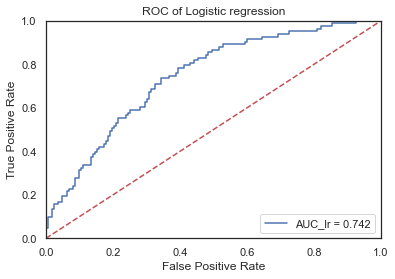

In [32]:
# Logistic regression ROC curve
y_scores = lm.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC_lr = %0.3f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC of Logistic regression')
plt.show()

## 2. KNN 

In [33]:
from sklearn.neighbors import KNeighborsClassifier

knn_3 = KNeighborsClassifier(n_neighbors=3)
knn_3.fit(X_train,y_train)
pred = knn_3.predict(X_test)

print('Accuracy score:',accuracy_score(y_test,pred),'\n')
print('Classification report (kNN, n=3):\n\n',classification_report(y_test,pred))

Accuracy score: 0.5294117647058824 

Classification report (kNN, n=3):

               precision    recall  f1-score   support

           0       0.78      0.42      0.55       172
           1       0.39      0.76      0.51        83

    accuracy                           0.53       255
   macro avg       0.58      0.59      0.53       255
weighted avg       0.65      0.53      0.53       255



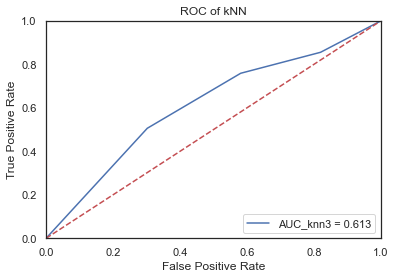

In [34]:
# knn=3 ROC curve
y_scores = knn_3.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label = 'AUC_knn3 = %0.3f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC of kNN')
plt.show()

## 3. Naive Bayes

In [35]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train,y_train)
pred = nb.predict(X_test)
print('Accuracy score:',accuracy_score(y_test,pred),'\n')
print('Classification report (Naive Bayes):\n\n',classification_report(y_test,pred))

Accuracy score: 0.48627450980392156 

Classification report (Naive Bayes):

               precision    recall  f1-score   support

           0       0.70      0.42      0.52       172
           1       0.34      0.63      0.44        83

    accuracy                           0.49       255
   macro avg       0.52      0.52      0.48       255
weighted avg       0.58      0.49      0.50       255



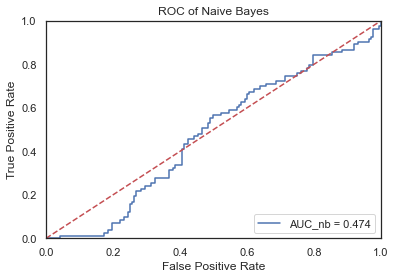

In [36]:
# Naive Bayes ROC curve
y_scores = nb.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC_nb = %0.3f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC of Naive Bayes')
plt.show()

## 4. Decision tree - classification

In [37]:
def quick_test(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

def quick_test_afew_times(model, X_train, y_train, X_test, y_test, n=10):
    return np.mean([quick_test(model, X_train, y_train, X_test, y_test) for j in range(n)])

In [38]:
from sklearn.svm import LinearSVC
# Linear SVC
linearsvc = LinearSVC()

# Do the test 10 times with a LinearSVC and get the average score
quick_test_afew_times(linearsvc, X_train, y_train, X_test, y_test)

/Users/katiehuang/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/katiehuang/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/katiehuang/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/katiehuang/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/katiehuang/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976

0.6274509803921567

In [39]:
from sklearn.tree import DecisionTreeClassifier
# Decision tree
decisiontree = DecisionTreeClassifier(max_depth=4)
quick_test_afew_times(decisiontree, X_train, y_train, X_test, y_test)

0.5101960784313725

In [40]:
pred = decisiontree.predict(X_test)
print('Accuracy score:',accuracy_score(y_test,pred),'\n')
print('Classification report (Decision Tree):\n\n',classification_report(y_test,pred))

Accuracy score: 0.5098039215686274 

Classification report (Decision Tree):

               precision    recall  f1-score   support

           0       0.70      0.48      0.57       172
           1       0.35      0.58      0.43        83

    accuracy                           0.51       255
   macro avg       0.52      0.53      0.50       255
weighted avg       0.59      0.51      0.52       255



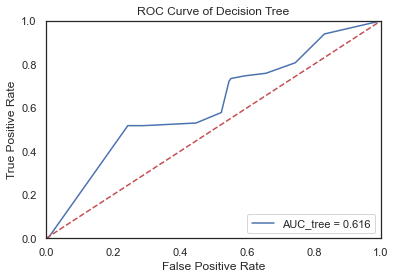

In [41]:
# Decision Tree ROC curve
y_scores = decisiontree.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC_tree = %0.3f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Decision Tree')
plt.show()

## 5. Random Forests

In [42]:
from sklearn.ensemble import RandomForestClassifier
# Random Forests
randomforest = RandomForestClassifier(n_estimators=200)
quick_test_afew_times(randomforest, X_train, y_train, X_test, y_test)

0.6905882352941177

In [43]:
pred = randomforest.predict(X_test)
print('Accuracy score:',accuracy_score(y_test,pred),'\n')
print('Classification report (Random Forests):\n\n',classification_report(y_test,pred))

Accuracy score: 0.6901960784313725 

Classification report (Random Forests):

               precision    recall  f1-score   support

           0       0.77      0.78      0.77       172
           1       0.53      0.51      0.52        83

    accuracy                           0.69       255
   macro avg       0.65      0.64      0.64       255
weighted avg       0.69      0.69      0.69       255



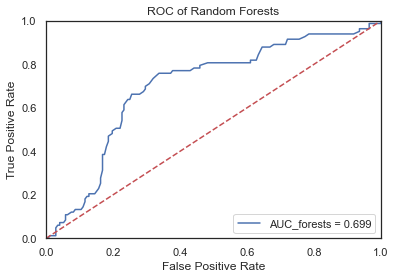

In [44]:
# Random Forests ROC curve
y_scores = randomforest.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC_forests = %0.3f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC of Random Forests')
plt.show()

In [45]:
interactive(lambda threshold: make_confusion_matrix(randomforest, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [46]:
# y_scores

## Examine model results

### 1. Check the best frame for each video file

In [47]:
test_df = df[df.video.isin(test_video)][['video','filename','label']].reset_index(drop=True)

model = randomforest
threshold = 0.56
y_predict = (model.predict_proba(X_test)[:, 1] >= threshold).tolist()
test_df['label'] = y_test
test_df['pred'] = [0 if x==False else 1 for x in y_predict]
test_df['prob'] = model.predict_proba(X_test)[:, 1]

In [48]:
test_df

video              filename  label  pred   prob
0    IMG_0185   IMG_0185.MOV_12.jpg      0     0  0.345
1    IMG_0185  IMG_0185.MOV_156.jpg      0     0  0.160
2    IMG_0185  IMG_0185.MOV_162.jpg      0     0  0.245
3    IMG_0185  IMG_0185.MOV_168.jpg      0     0  0.365
4    IMG_0185  IMG_0185.MOV_174.jpg      0     0  0.185
..        ...                   ...    ...   ...    ...
250  IMG_0257  IMG_0257.MOV_156.jpg      1     1  0.570
251  IMG_0257  IMG_0257.MOV_168.jpg      1     1  0.635
252  IMG_0257  IMG_0257.MOV_246.jpg      1     0  0.535
253  IMG_0257   IMG_0257.MOV_72.jpg      1     1  0.605
254  IMG_0257   IMG_0257.MOV_84.jpg      1     1  0.660

[255 rows x 5 columns]

In [49]:
test_df['prob_max'] = test_df.groupby(['video'])['prob'].transform(max)

In [50]:
# test_df[test_df.video=="IMG_0187"].sort_values('prob',ascending=False)

In [51]:
results = test_df[test_df['prob'] == test_df['prob_max']][['video','filename','label','prob']]
results

video              filename  label   prob
6    IMG_0185  IMG_0185.MOV_192.jpg      0  0.505
18   IMG_0186  IMG_0186.MOV_132.jpg      0  0.540
59   IMG_0187  IMG_0187.MOV_126.jpg      0  0.860
92   IMG_0242   IMG_0242.MOV_66.jpg      0  0.510
95   IMG_0243  IMG_0243.MOV_108.jpg      0  0.405
133  IMG_0245  IMG_0245.MOV_210.jpg      0  0.765
148  IMG_0250   IMG_0250.MOV_42.jpg      0  0.455
207  IMG_0244  IMG_0244.MOV_270.jpg      1  0.775
241  IMG_0246   IMG_0246.MOV_60.jpg      1  0.600
244  IMG_0251   IMG_0251.MOV_72.jpg      1  0.575
246  IMG_0253  IMG_0253.MOV_156.jpg      1  0.420
254  IMG_0257   IMG_0257.MOV_84.jpg      1  0.660

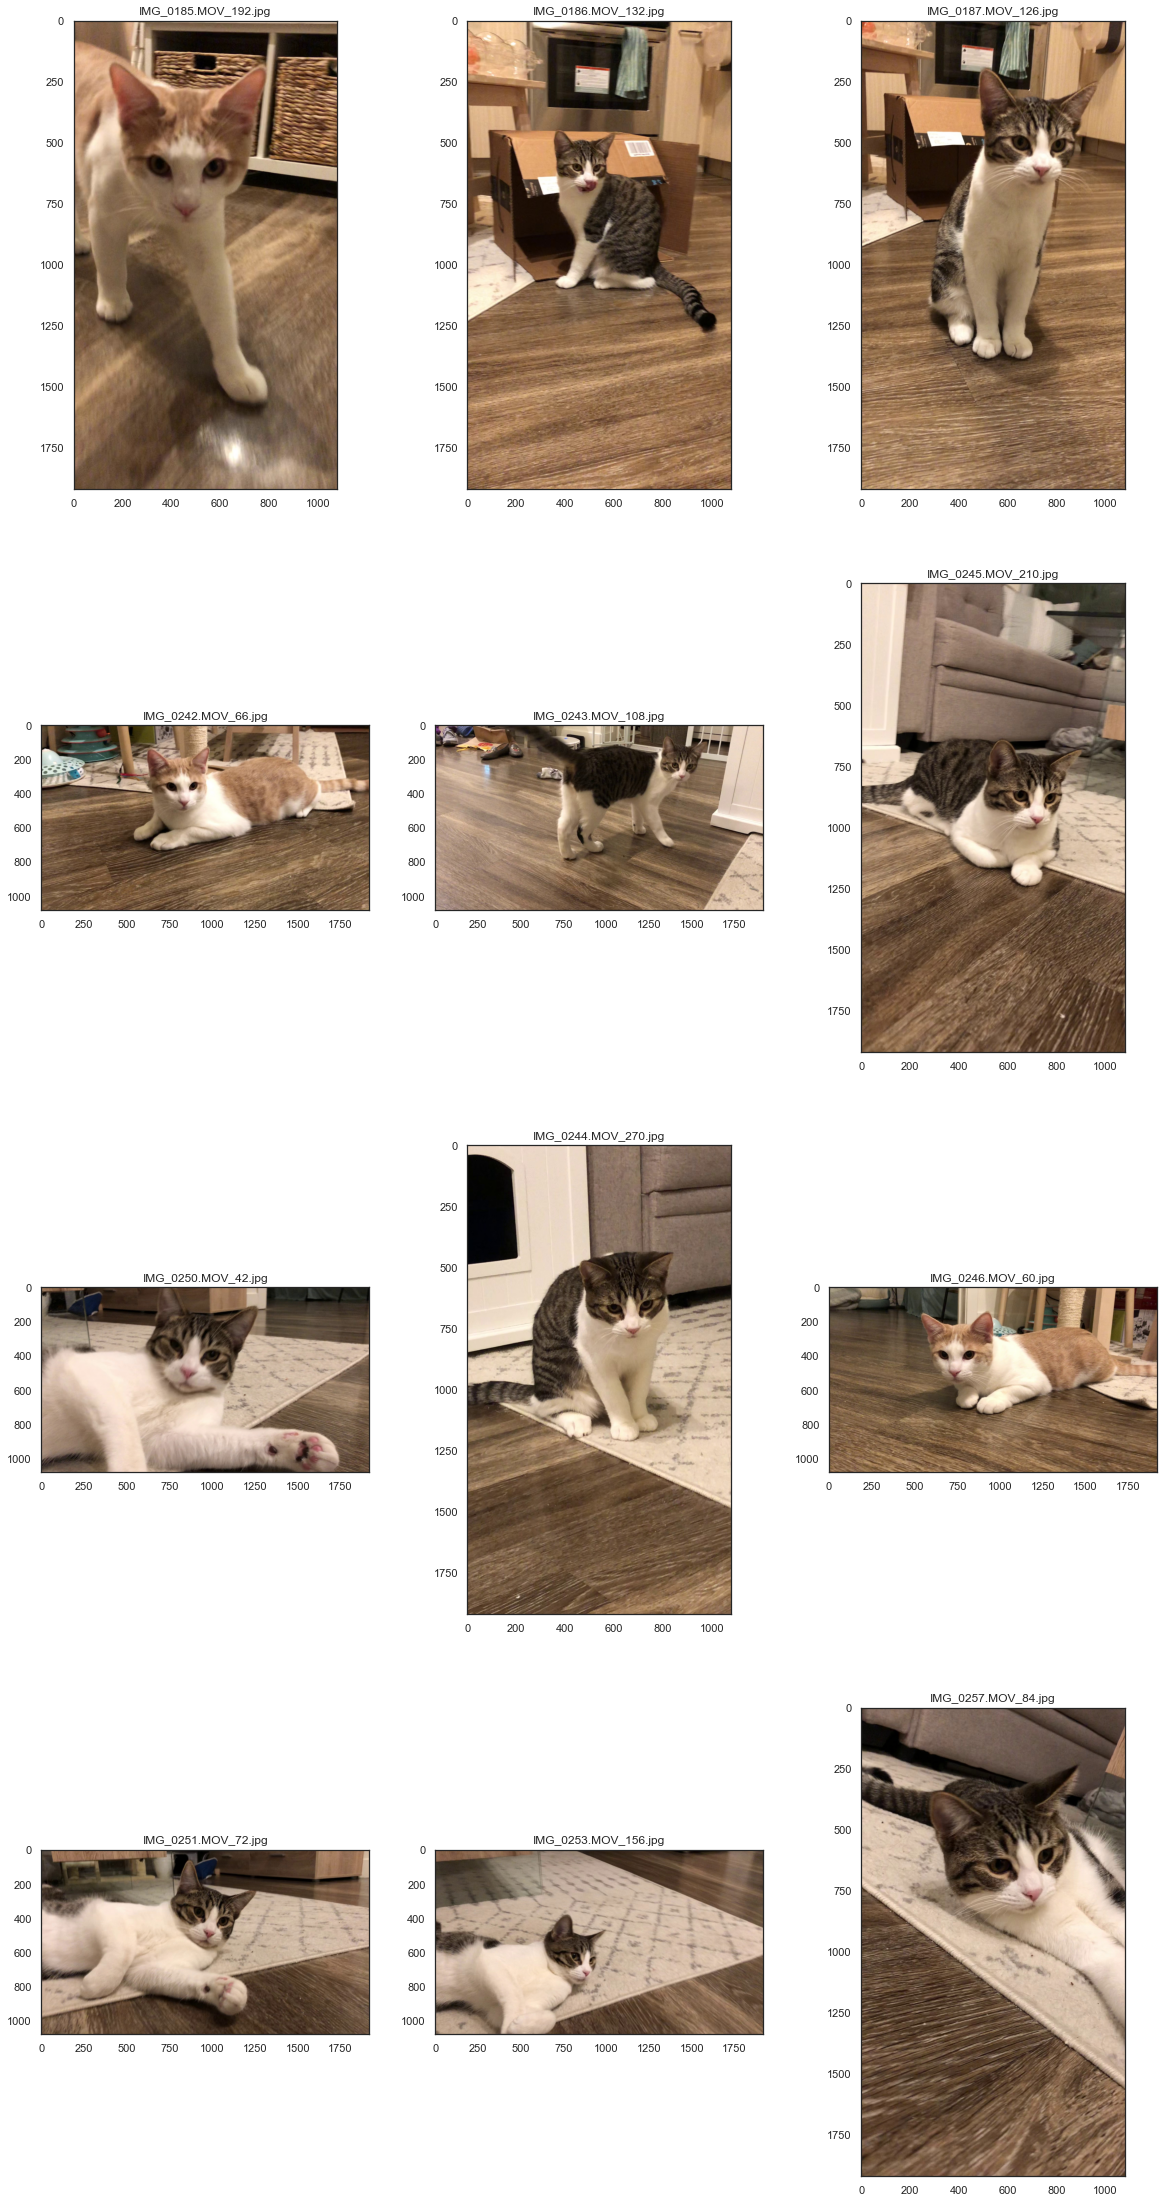

In [52]:
import cv2 as cv

# Text parameters 
font = cv.FONT_HERSHEY_SIMPLEX
org = (800, 100)
fontScale = 2
color = (255, 0, 0)
thickness = 2

# List of lp_ratio
# lp_ratios = [round(x,4) for x in FP.lp_ratio.tolist()]

# Prepare list of best frames
selected_img = results.filename.tolist()
test_len = len(results)

# Plots
subplot_row = test_len//3+1
fig, axs = plt.subplots(figsize=(20, 10*subplot_row))
for i, filename in enumerate(selected_img[:]):
    img = cv.imread('OpenCV_blur/frame_all/'+filename)
    rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    
#     # Annotate lp_ratio
#     lp_ratio = str(lp_ratios[i])
#     rgb = cv.putText(rgb, lp_ratio,org, font,  
#                    fontScale, color, thickness, cv.LINE_AA) 
    plt.subplot(subplot_row,3,i+1)
    plt.imshow(rgb)
    plt.title(filename)

plt.show()

### Check false positive images

In [53]:
# False-positive: bad photos but predicted to be good
FP = test_df[(test_df.label==0) & (test_df.pred==1)]
FP_img = FP.filename.tolist()
FP_len = len(FP_img)
FP_len

29

In [54]:
# False-positive: bad photos but predicted to be good
FP = results[(results.label==0)]
FP_img = FP.filename.tolist()
FP_len = len(FP_img)
FP_len

7

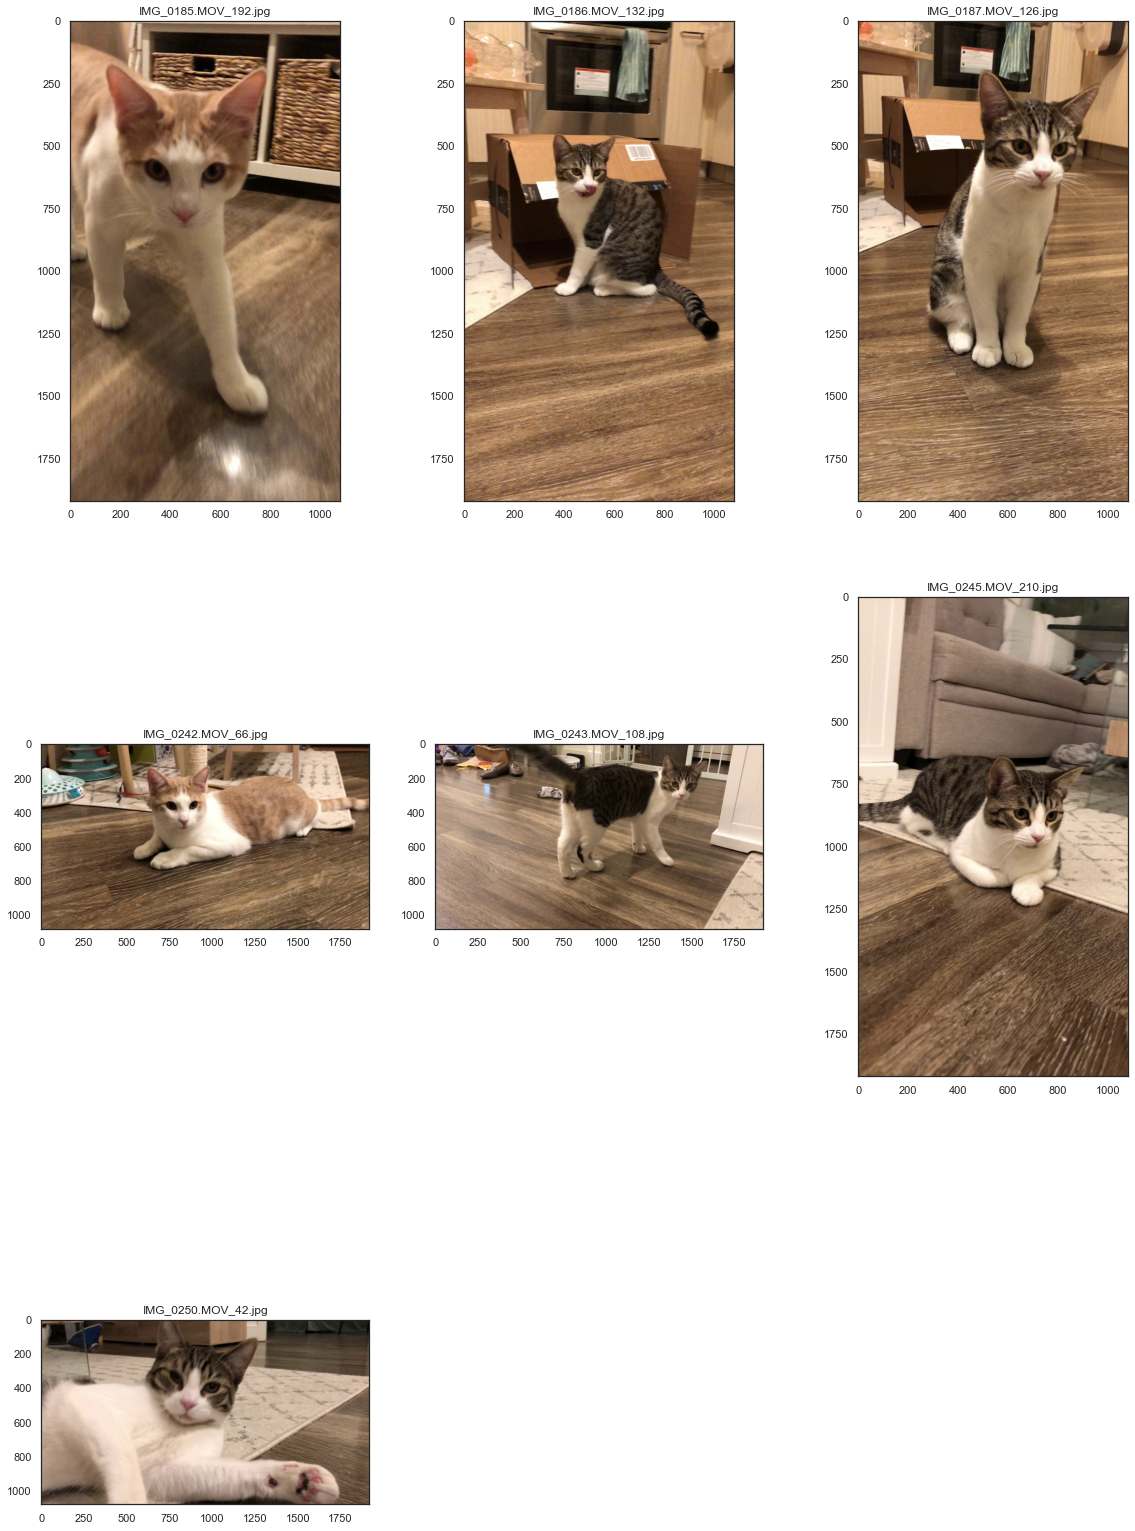

In [55]:
import cv2 as cv

# Plots
subplot_row = FP_len//3+1
fig, axs = plt.subplots(figsize=(20, 10*subplot_row))
for i, filename in enumerate(FP_img[:]):
    img = cv.imread('OpenCV_blur/frame_all/'+filename)
    rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    
#     # Annotate lp_ratio
#     lp_ratio = str(lp_ratios[i])
#     rgb = cv.putText(rgb, lp_ratio,org, font,  
#                    fontScale, color, thickness, cv.LINE_AA) 
    plt.subplot(subplot_row,3,i+1)
    plt.imshow(rgb)
    plt.title(filename)

plt.show()